# Taylor-Couette Benchmarking

Results from table 1 of Marcus (1984a, JFM). Run labels are our own.

For runs B and C, the growth rates from Chandrasekhar (1961) and Krueger, Gross, and DiPrima (1966) are given in parentheses. In both cases, those are zero. This means that depsite the fact that we disagree significantly from Marcus (1984) for those cases, in one we are closer to the previously published growth rates and in one we are further away.

| Run | $\eta$ | Re | $\mu$ | $\alpha$ | $L_z$ | $m_1$ | Growth rate| Notes |
| -- | -- | -- | -- | -- | -- | -- | -- | -- |
| A | 0.5 | 74.924 | 0 | 3.161 | 1.988 | 0 | 0.035636 | |
| B | 0.95 | 184.99 | 0 | 3.128 | 2.009 | 0 | 5.16e-4 (0.) | |
| C | 0.5 | 63.134 | 0.11765 | 3.1 | 2.207 | 0 | 1.57e-2 (0.) | |
| D | 0.877 | 1191.0 | 0 | 2.662 | 2.360 | 6 | 0.073225 | |
| E | 0.875 | 139.32 | 0 | 2.513 | 2.5 | 0 | -- | |
| F | 0.875 | 243.81 | 0 | 2.094 | 3. | 6 | -- | Willis ICs |
| G | 0.875 | 243.81 | 0 | 2.094 | 3. | 6 | -- | noise ICs |
| H | 0.875 | 243.81 | 0 | 2.094 | 3. | 6 | -- | single mode ICs |
| I | 0.868 | 458.10 | 0 | 2.618 | 2.40 | 6 | -- | noise ICs |
| J | 0.868 | 458.10 | 0 | 2.618 | 2.40 | 6 | -- | noise ICs; theta symmetry |
| K | 0.875 | 243.81 | 0 | 2.094 | 3. | 6 | -- | noise ICs; theta symmetry |
| L | 0.875 | 243.81 | 0 | 2.094 | 3. | 6 | -- | noise ICs; full equations with $v_0$ on grid |
| M | 0.875 | 243.81 | 0 | 2.094 | 3. | 6 | -- | noise ICs; theta symmetry; different random seed |
| N | 0.875 | 243.81 | 0 | 2.094 | 3. | 6 | -- | noise ICs; theta symmetry; full equations with $v_0$ on grid |

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
import re
import dedalus.extras.plot_tools as pt

plt.style.use('modern')

In [3]:
def find_fourier_right(grid):
    delta = grid[1]-grid[0]
    
    return grid[-1] + delta

def fourier_grid_width(grid):
    right = find_fourier_right(grid)
    
    return right - grid[0]

In [4]:
class Timeseries:
    def __init__(self, filename, ref_growth=None):
        self.fn = filename
        self.ref_growth = ref_growth
        
        self.eta = float(re.search("eta_([\d.e+-]+)",self.fn).group(1))
        self.R1 = self.eta/(1. - self.eta)
        self.R2 = 1./(1-self.eta)
        self.Omega1 = 1/self.R1
        self.period = 2*np.pi/self.Omega1
        self.Lz = float(re.search("Gamma_([\d.e+-]+)",self.fn).group(1))
        with h5py.File(self.fn, "r") as ts:
            self.t = ts['scales/sim_time'][:]
            self.w_rms = ts['tasks/w_rms'][:,0,0,0]
            self.KE = ts['tasks/KE'][:,0,0,0]/self.Lz
            self.enstrophy = ts['tasks/enstrophy'][:,0,0,0]/self.Lz

        
    def analyze_growth(self, window=(2,14)):
        self.t_window = (self.t/self.period > window[0]) & (self.t/self.period < window[1])
        self.gamma_w, self.log_w0 = np.polyfit(self.t[self.t_window], np.log(self.w_rms[self.t_window]),1)

    @property
    def rel_error(self):
        if self.ref_growth is None:
            raise ValueError("Unspecified reference value for relative error calculation.")

        rel_error = (self.gamma_w - self.ref_growth)/self.ref_growth
        return rel_error

    def plot(self, ax=None):
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)
        ax.semilogy(self.t/self.period,self.w_rms)
        ax.semilogy(self.t/self.period, np.exp(self.log_w0)*np.exp(self.gamma_w*self.t), '-.', label='$\gamma_w = %f$' % self.gamma_w)
        ax.set_xlabel(r"$t/period$")
        ax.set_ylabel(r"$w_{rms}$")
        ax.legend()
        plt.tight_layout()
        
    def plot_en_ens(self):
        plt.figure()
        plt.subplot(211)
        plt.plot(run_I.t/run_I.period, run_I.KE)
        plt.xlabel("t/period")
        plt.ylabel("Kinetic energy")
        plt.subplot(212)
        plt.plot(run_I.t/run_I.period, run_I.enstrophy)
        plt.xlabel("t/period")
        plt.ylabel("enstrophy")
        plt.tight_layout()

In [5]:
gamma_marcus_A = 0.035636
run_A = Timeseries("results/TC_3d_re_74.924_eta_5.0000e-01_Gamma_1.988_M1_6_32_32_32/scalar/scalar_s1.h5", ref_growth=gamma_marcus_A)
run_A.analyze_growth()

/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


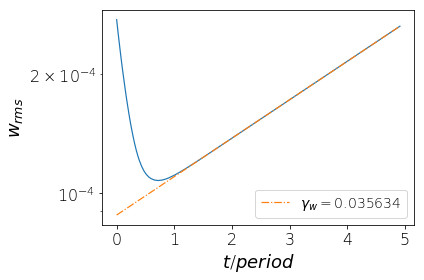

In [6]:
run_A.plot()

In [7]:
print("Run A error: {:e}".format(run_A.rel_error))

Run A error: -4.887516e-05


In [8]:
gamma_marcus_B = 4.35e-4
run_B = Timeseries("results/TC_3d_re_1.849900e+02_eta_9.500000e-01_Gamma_2.008000e+00_M1_6_32_32_32/scalar/scalar_s1.h5",ref_growth=gamma_marcus_B)
run_B.analyze_growth()

In [9]:
run_B.eta

0.95

In [10]:
print("Run B error: {:e}".format(run_B.rel_error))

Run B error: -9.940805e-01


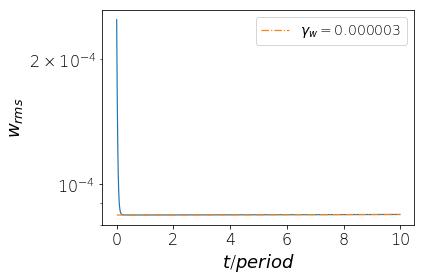

In [11]:
run_B.plot()

In [12]:
gamma_marcus_C = 1.57e-2
run_C = Timeseries("results/TC_3d_re_6.313400e+01_eta_5.000000e-01_Gamma_2.027000e+00_M1_6_32_32_32/scalar/scalar_s1.h5",ref_growth=gamma_marcus_C)
run_C.analyze_growth()

In [13]:
print("Run C error: {:e}".format(run_C.rel_error))

Run C error: -7.138678e+00


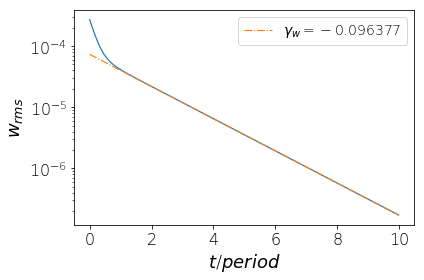

In [14]:
run_C.plot()

In [15]:
run_D_file = "results/TC_3d_re_1.191000e+03_eta_8.770000e-01_Gamma_2.360000e+00_M1_6_32_32_32/scalar/scalar_s1.h5"
gamma_marcus_D = 0.073225
run_D = Timeseries(run_D_file,ref_growth=gamma_marcus_D)
run_D.analyze_growth(window=(0.5,0.7))

In [16]:
print("Run D error: {:e}".format(run_D.rel_error))

Run D error: 2.047446e+00


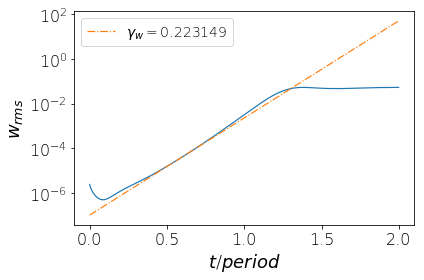

In [17]:
run_D.plot()

## Run E

This allows a test of the non-linear terms for an axisymmetric case. 

Marcus (1984b) reports the Kinetic energy per $L_z$ for these parameters both for the initially unstable Circular Couette Flow and his own non-linear saturation energy in Taylor Vortex Flow to three digits of precision.

He does not report the growth rate for this run, but here's the plot anyway.

In [18]:
run_E_file = "results/TC_3d_re_1.393200e+02_eta_8.750000e-01_Gamma_2.500000e+00_M1_0_32_32_32/scalar/scalar_s1.h5"
gamma_marcus_E = 0.073225
run_E = Timeseries(run_E_file,ref_growth=gamma_marcus_E)
run_E.analyze_growth(window=(0.5,0.7))

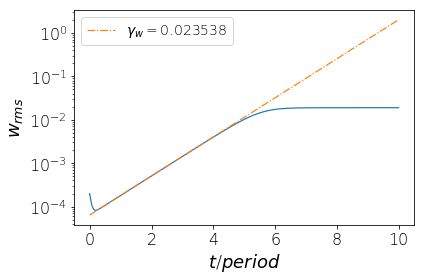

In [19]:
run_E.plot()

This is the analytic formula for Circular Couette Flow Energy:

In [20]:
def ECC(eta): 
    return np.pi*eta**2/((1-eta)**3 * (1+eta)) *((eta**2 -3 )/4 - np.log(eta)/(1-eta**2)) 

For this run, $L_z = 2.5$.

In [21]:
run_E.Lz

2.5

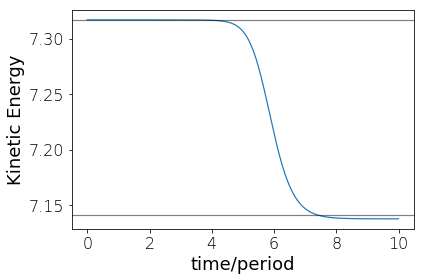

In [22]:
plt.figure()
plt.plot(run_E.t/run_E.period,run_E.KE)
plt.xlabel('time/period')
plt.ylabel('Kinetic Energy')
plt.axhline(ECC(run_E.eta),color='k',alpha=0.5)
plt.axhline(ECC(run_E.eta)*0.976,color='k',alpha=0.5)

plt.tight_layout()

In [23]:
print("Marcus Final KE: {:5.2f}".format(ECC(run_E.eta)*0.976))
print("Our Final KE: {:5.2f}".format(run_E.KE[-1]))

Marcus Final KE:  7.14
Our Final KE:  7.14


In [24]:
print("Marcus Final Enstrophy: {:5.1f}".format(27.1))
print("Our Final Enstrophy: {:5.1f}".format(run_E.enstrophy[-1]))

Marcus Final Enstrophy:  27.1
Our Final Enstrophy:  27.1


So we agree to all reported digits in both energy and enstrophy per unit length.

In [25]:
run_E_snaps = h5py.File("results/TC_3d_re_1.393200e+02_eta_8.750000e-01_Gamma_2.500000e+00_M1_0_32_32_32/snapshots/snapshots_s1.h5","r")

In [26]:
def plot_TC_velocity(dataset,iteration,ntheta=0,width = 2.1, field='v', quiver=True):
    task_name = 'tasks/'+field
    Lz = fourier_grid_width(dataset['scales/z/1.0'][:])
    box = pt.Box(width,width*Lz)
    pad = pt.Frame(0.4, 0.4, 0.1, 0.1)
    margin = pt.Frame(0.4, 0.4, 0.3, 0.3)
    mfig = pt.MultiFigure(1,1,box,pad,margin)
    ax = mfig.add_axes(0,0,[0,0,1,1])
    data_slices = (iteration,slice(None),ntheta,slice(None))
    xaxis = 3
    yaxis = 1
    xscale, yscale = 0,0 
    ax, cb = pt.plot_bot(dataset[task_name],(xaxis,yaxis),data_slices,image_scales=(xscale,yscale),axes=ax)
    if quiver:
        xmesh, ymesh, xdata = pt.get_plane(dataset['tasks/u'], xaxis, yaxis, data_slices, xscale, yscale)
        xmesh, ymesh, ydata = pt.get_plane(dataset['tasks/w'], xaxis, yaxis, data_slices, xscale, yscale)
        ax.quiver(xmesh[:-1,:-1],ymesh[:-1,:-1],xdata,ydata)

In [27]:
def plot_vel_tz(dataset,iteration,nr=None,height=2,ar=None, field='v', quiver=True):
    task_name = 'tasks/'+field
    if nr is None:
        nr = int(dataset[task_name].shape[-1]/2)
    Lz = fourier_grid_width(dataset['scales/z/1.0'][:])
    Lt = 2*np.pi
    if ar is None:
        ar = Lt
    box = pt.Box(ar*height,height)
    pad = pt.Frame(0.4, 0.4, 0.1, 0.1)
    margin = pt.Frame(0.4, 0.4, 0.3, 0.3)
    mfig = pt.MultiFigure(1,1,box,pad,margin)
    ax = mfig.add_axes(0,0,[0,0,1,1])
    data_slices = (iteration,slice(None),slice(None),nr)
    xaxis = 2
    yaxis = 1
    xscale, yscale = 0,0 
    ax, cb = pt.plot_bot(dataset[task_name],(xaxis,yaxis),data_slices,image_scales=(xscale,yscale),axes=ax)
    if quiver:
        xmesh, ymesh, xdata = pt.get_plane(dataset['tasks/v'], xaxis, yaxis, data_slices, xscale, yscale)
        xmesh, ymesh, ydata = pt.get_plane(dataset['tasks/w'], xaxis, yaxis, data_slices, xscale, yscale)
        ax.quiver(xmesh[:-1,:-1],ymesh[:-1,:-1],xdata,ydata)

In [28]:
run_D_snaps = h5py.File("results/TC_3d_re_1.191000e+03_eta_8.770000e-01_Gamma_2.360000e+00_M1_6_32_32_32/snapshots/snapshots_s1.h5", "r")

In [29]:
run_D_snaps['scales/z/1.0'][-1]-run_D_snaps['scales/z/1.0'][0]

2.28625

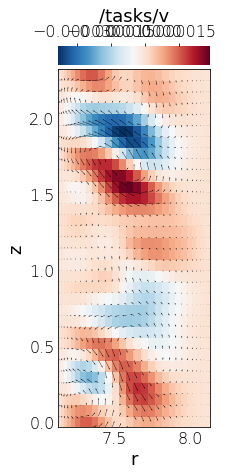

In [30]:
plot_TC_velocity(run_D_snaps,3,0)

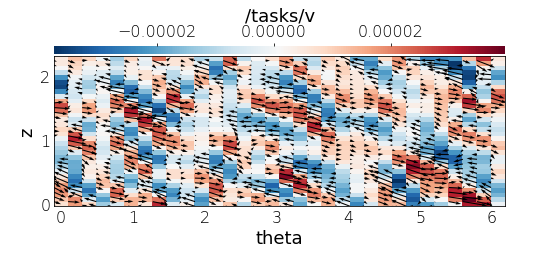

In [31]:
plot_vel_tz(run_D_snaps,3,ar = 3)

In [32]:
run_A_snaps = h5py.File("results/TC_3d_re_74.924_eta_5.0000e-01_Gamma_1.988_M1_6_32_32_32/snapshots/snapshots_s1.h5","r") 

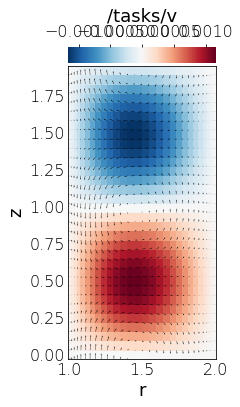

In [33]:
plot_TC_velocity(run_A_snaps,-5,0)

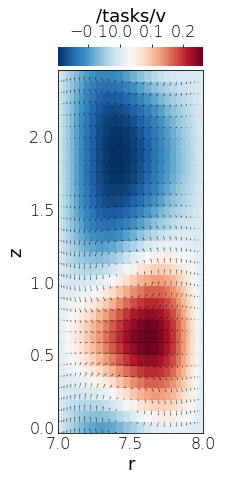

In [34]:
plot_TC_velocity(run_E_snaps,-1,10)

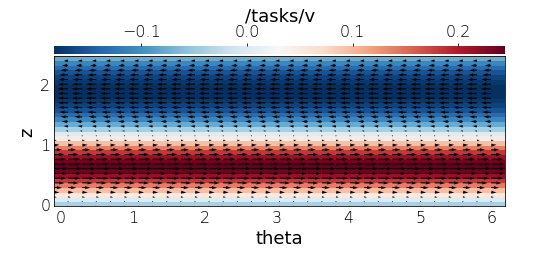

In [35]:
plot_vel_tz(run_E_snaps,-1, ar=3)

In [36]:
run_F_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_noherm/"
run_F_snaps = h5py.File(run_F_directory+"/snapshots/snapshots_s1.h5","r")

In [37]:
ECC(0.868)

6.871861847221468

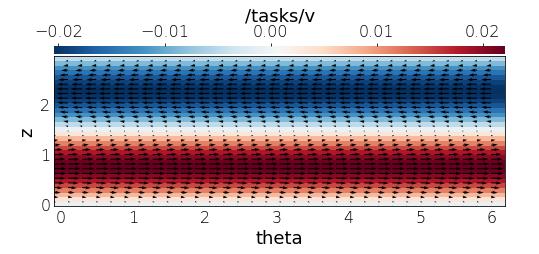

In [38]:
plot_vel_tz(run_F_snaps,10, ar=3)

In [39]:
run_F_snaps['scales/sim_time'][:]

array([  0.        ,   4.52320313,   9.42473145,  13.88463379,
        17.88463379,  22.88463379,  26.88463379,  30.88463379,
        35.88463379,  39.88463379,  44.88463379,  48.88463379,
        52.88463379,  57.36525344,  61.62112964,  66.17827098,
        70.40588134,  74.83056151,  79.18205987,  83.57572294,
        88.00135742,  92.39450446,  96.7876515 , 101.1909279 ,
       105.57715094, 109.96337398, 114.40001337, 118.78623641,
       123.17245945, 127.55868249, 131.99532189, 136.38154493,
       140.76776797, 145.15399101, 149.55755347, 153.94113141,
       158.38019768, 162.76377562, 167.14735356, 171.58641983,
       175.96999777, 180.35357571, 184.73715365, 189.17621992,
       193.55979786, 197.9433758 , 202.32695374, 206.76602001,
       211.14959795, 215.53317589, 219.91675383, 224.3558201 ,
       228.73939804, 233.12297598, 237.50655392, 241.94562019,
       246.32919813, 250.71277607, 255.15184234, 259.53542028,
       263.91899822, 268.30257616, 272.74164243, 277.12

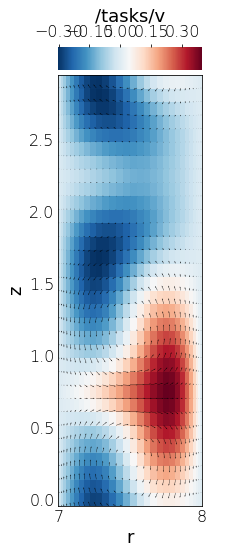

In [40]:
plot_TC_velocity(run_F_snaps,23,0)

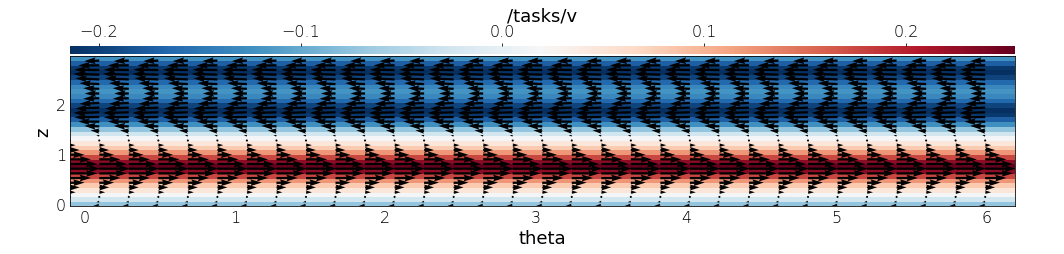

In [41]:
plot_vel_tz(run_F_snaps,23)

In [42]:
run_F = Timeseries(run_F_directory+"scalar/scalar_s1.h5")
run_F.analyze_growth(window=(0.5,1))

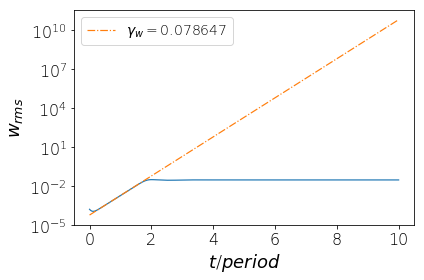

In [43]:
run_F.plot()

Text(0, 0.5, 'Kinetic Energy')

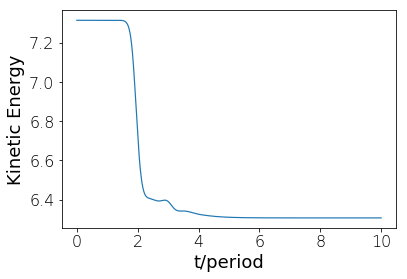

In [44]:
plt.figure()
plt.plot(run_F.t/run_F.period, run_F.KE)
plt.xlabel("t/period")
plt.ylabel("Kinetic Energy")

In [45]:
run_G_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_noise_IC/"
run_G_snaps = h5py.File(run_G_directory+"/snapshots/snapshots_s1.h5","r")
run_G = Timeseries(run_G_directory+"scalar/scalar_s1.h5")
run_G.analyze_growth(window=(0.5,1))

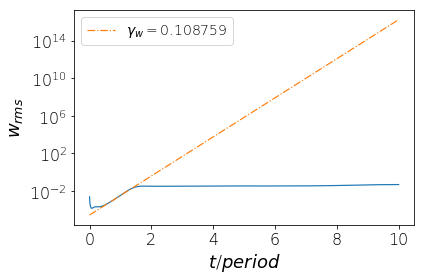

In [46]:
run_G.plot()

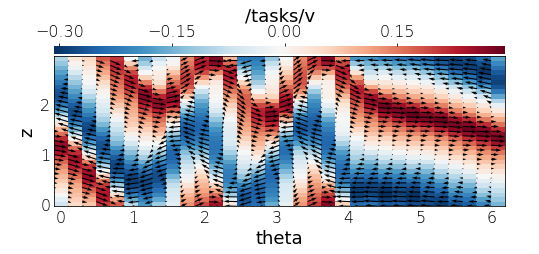

In [47]:
plot_vel_tz(run_G_snaps,-2,ar = 3)

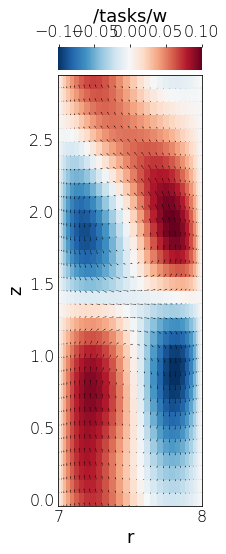

In [48]:
plot_TC_velocity(run_G_snaps,-1,field='w')

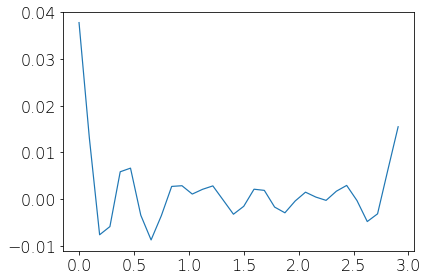

In [49]:
plt.figure()
plt.plot(run_G_snaps['scales/z/1.0'][:], run_G_snaps['tasks/w'][0,10,0,:])
plt.tight_layout()

In [50]:
spec = np.fft.rfftn(run_G_snaps['tasks/w'][-1,:,:,15])

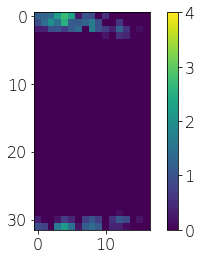

In [51]:
plt.figure()
plt.imshow(np.log(np.abs(spec)),vmin=0,vmax=4)
plt.colorbar()

In [52]:
run_H_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_singlemode_IC/"
run_H = Timeseries(run_H_directory+"/scalar/scalar_s1.h5")
run_H_snaps = h5py.File(run_H_directory+"/snapshots/snapshots_s1.h5","r")
run_H.analyze_growth(window=(1,1.5))

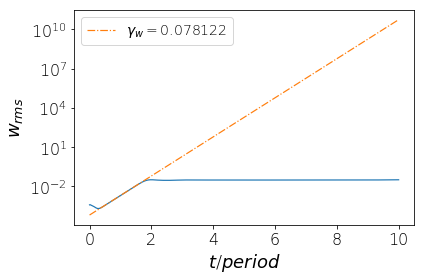

In [53]:
run_H.plot()

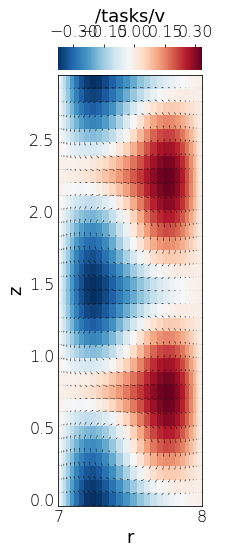

In [54]:
plot_TC_velocity(run_H_snaps,-1)

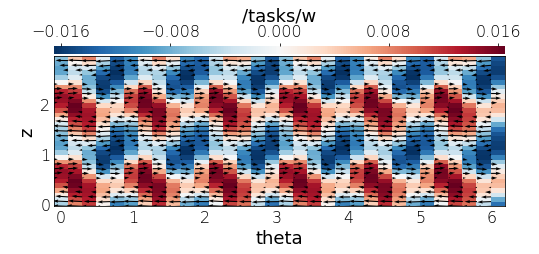

In [55]:
plot_vel_tz(run_H_snaps,-3,field='w',ar=3,nr=15)

In [56]:
spec_H = np.fft.rfftn(run_H_snaps['tasks/w'][-1,:,:,15])
spec_H_IC = np.fft.rfftn(run_H_snaps['tasks/v'][0,:,:,15])

/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


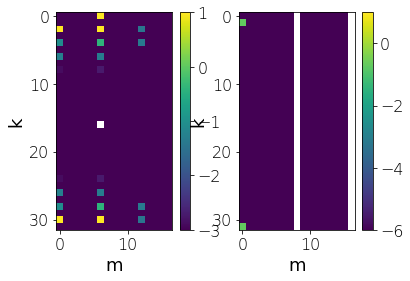

In [57]:
plt.figure()
plt.subplot(121)
plt.imshow(np.log(np.abs(spec_H)),vmin=-3,vmax=1)
plt.xlabel("m")
plt.ylabel("k")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log(np.abs(spec_H_IC)),vmin=-6,vmax=1)
plt.xlabel("m")
plt.ylabel("k")
plt.colorbar()

In [58]:
spec_H[16,6]

0j

In [59]:
run_I_directory = "results/TC_3d_re_4.581000e+02_eta_8.680000e-01_Gamma_2.400000e+00_M1_6_32_32_32_noise_IC/"
run_I = Timeseries(run_I_directory+"scalar/scalar_s1.h5")
run_I.analyze_growth(window=(0.5,0.7))
run_I_snaps = h5py.File(run_I_directory+"snapshots/snapshots_s1.h5","r")

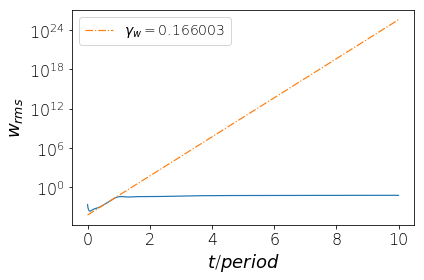

In [60]:
run_I.plot()

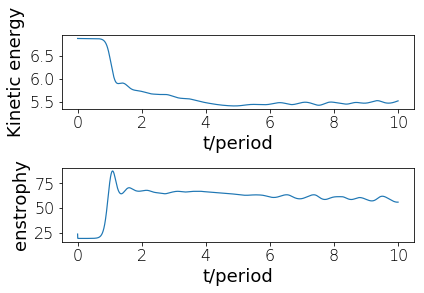

In [61]:
run_I.plot_en_ens()

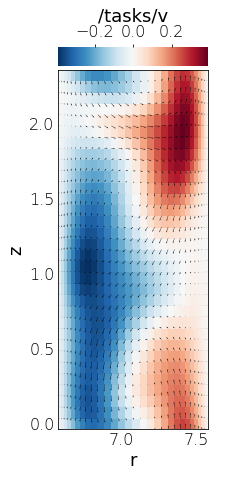

In [62]:
plot_TC_velocity(run_I_snaps,-1)

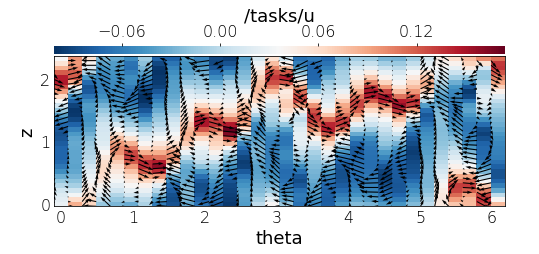

In [63]:
plot_vel_tz(run_I_snaps,-1,ar=3,field='u')

In [64]:
spec_I = np.fft.rfftn(run_I_snaps['tasks/w'][-1,:,:,15])
#spec_H_IC = np.fft.rfftn(run_H_snaps['tasks/v'][0,:,:,15])

/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


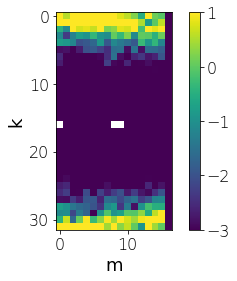

In [65]:
plt.figure()

plt.imshow(np.log(np.abs(spec_I)),vmin=-3,vmax=1)
plt.xlabel("m")
plt.ylabel("k")
plt.colorbar()

In [66]:
run_J_directory = "results/TC_3d_re_4.581000e+02_eta_8.680000e-01_Gamma_2.400000e+00_M1_6_32_32_32_noise_IC_theta_symmetry/"
run_J = Timeseries(run_J_directory+"scalar/scalar_s1.h5")
run_J.analyze_growth(window=(0.5,0.7))
run_J_snaps = h5py.File(run_J_directory+"snapshots/snapshots_s1.h5","r")

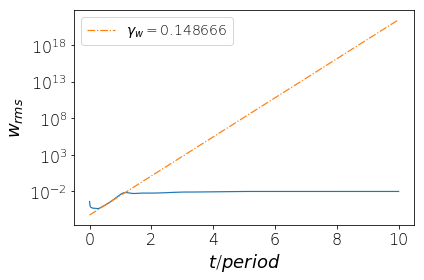

In [67]:
run_J.plot()

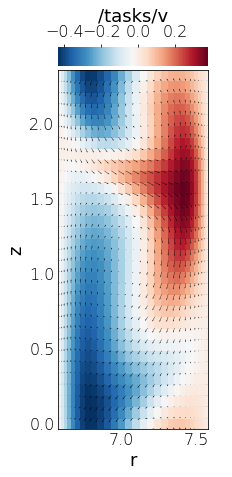

In [68]:
plot_TC_velocity(run_J_snaps, -1)

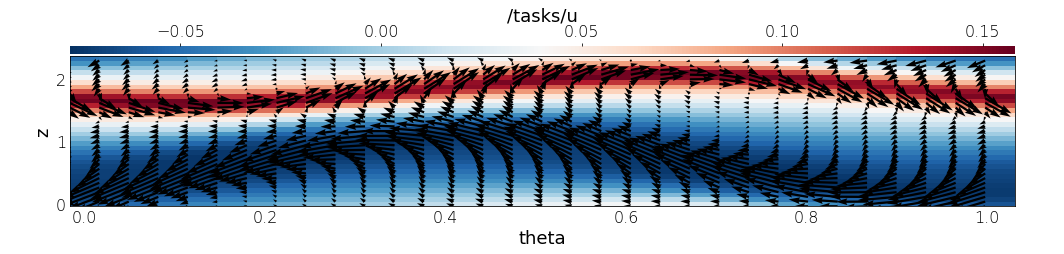

In [69]:
plot_vel_tz(run_J_snaps, -1, field='u')

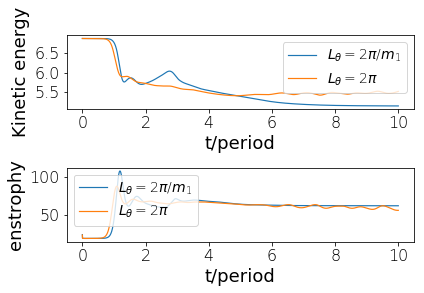

In [70]:
plt.figure()
plt.subplot(211)
plt.plot(run_J.t/run_J.period, run_J.KE*6, label=r'$L_\theta = 2\pi/m_1$')
plt.plot(run_I.t/run_I.period, run_I.KE, label=r'$L_\theta = 2\pi$')
plt.legend()
plt.xlabel("t/period")
plt.ylabel("Kinetic energy")
plt.subplot(212)
plt.plot(run_J.t/run_J.period, run_J.enstrophy*6, label=r'$L_\theta = 2\pi/m_1$')
plt.plot(run_I.t/run_I.period, run_I.enstrophy, label=r'$L_\theta = 2\pi$')
plt.legend()
plt.xlabel("t/period")
plt.ylabel("enstrophy")
plt.tight_layout()

In [71]:
spec_J = np.fft.rfftn(run_J_snaps['tasks/w'][-1,:,:,15])
spec_J_IC = np.fft.rfftn(run_J_snaps['tasks/w'][0,:,:,15])

/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


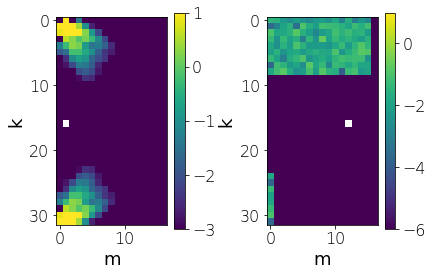

In [72]:
plt.figure()
plt.subplot(121)
plt.imshow(np.log(np.abs(spec_J)),vmin=-3,vmax=1)
plt.xlabel("m")
plt.ylabel("k")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log(np.abs(spec_J_IC)),vmin=-6,vmax=1)
plt.xlabel("m")
plt.ylabel("k")
plt.colorbar()
plt.tight_layout()

In [73]:
run_K_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_noise_IC_theta_symmetry/"
run_K = Timeseries(run_K_directory+"scalar/scalar_s1.h5")
run_K.analyze_growth(window=(0.5,0.7))
run_K_snaps = h5py.File(run_K_directory+"snapshots/snapshots_s1.h5","r")

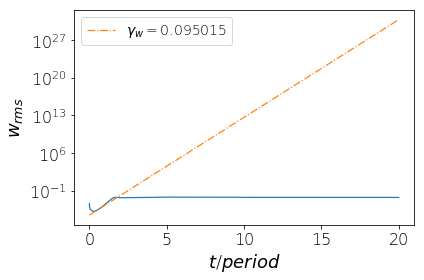

In [74]:
run_K.plot()

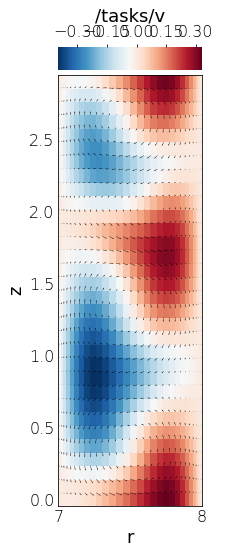

In [75]:
plot_TC_velocity(run_K_snaps, -1)

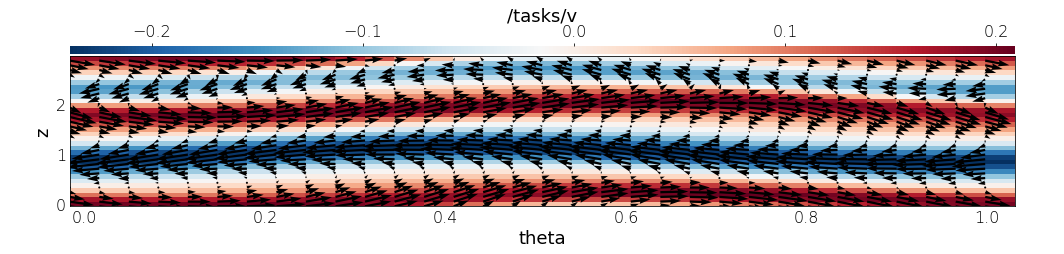

In [76]:
plot_vel_tz(run_K_snaps, -1)

In [77]:
spec_K = np.fft.rfftn(run_K_snaps['tasks/w'][-1,:,:,15])
spec_K_IC = np.fft.rfftn(run_K_snaps['tasks/w'][0,:,:,15])

/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


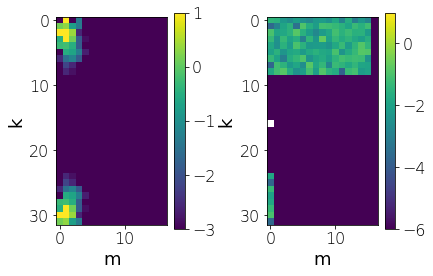

In [78]:
plt.figure()
plt.subplot(121)
plt.imshow(np.log(np.abs(spec_K)),vmin=-3,vmax=1)
plt.xlabel("m")
plt.ylabel("k")
plt.colorbar()
plt.subplot(122)
plt.imshow(np.log(np.abs(spec_K_IC)),vmin=-6,vmax=1)
plt.xlabel("m")
plt.ylabel("k")
plt.colorbar()
plt.tight_layout()

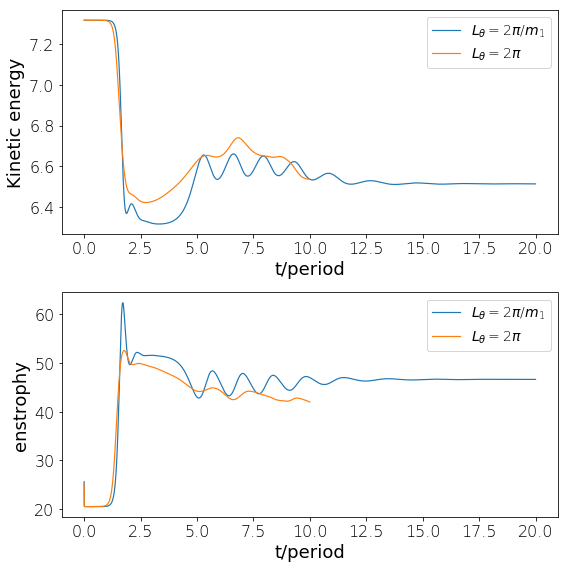

In [79]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(run_K.t/run_K.period, run_K.KE*6, label=r'$L_\theta = 2\pi/m_1$')
plt.plot(run_G.t/run_G.period, run_G.KE, label=r'$L_\theta = 2\pi$')
plt.legend()
plt.xlabel("t/period")
plt.ylabel("Kinetic energy")
plt.subplot(212)
plt.plot(run_K.t/run_K.period, run_K.enstrophy*6, label=r'$L_\theta = 2\pi/m_1$')
plt.plot(run_G.t/run_G.period, run_G.enstrophy, label=r'$L_\theta = 2\pi$')
plt.legend()
plt.xlabel("t/period")
plt.ylabel("enstrophy")
plt.tight_layout()

In [80]:
run_L_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_noise_IC_full_eqn/"
run_L = Timeseries(run_L_directory+"scalar/scalar_s1.h5")
run_L.analyze_growth(window=(0.5,0.7))
run_L_snaps = h5py.File(run_L_directory+"snapshots/snapshots_s1.h5","r")

In [82]:
run_M_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_noise_IC_seed_44_theta_symmetry/"
run_M = Timeseries(run_M_directory+"scalar/scalar_s1.h5")
run_M.analyze_growth(window=(0.5,0.7))
run_M_snaps = h5py.File(run_M_directory+"snapshots/snapshots_s1.h5","r")

In [83]:
run_N_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_noise_IC_full_eqn_theta_symmetry/"
run_N = Timeseries(run_N_directory+"scalar/scalar_s1.h5")
run_N.analyze_growth(window=(0.5,0.7))
run_N_snaps = h5py.File(run_N_directory+"snapshots/snapshots_s1.h5","r")

In [84]:
run_O_directory = "results/TC_3d_re_1.191000e+03_eta_8.770000e-01_Gamma_2.360000e+00_M1_6_32_32_32_theta_symmetry/"
run_O = Timeseries(run_O_directory+"scalar/scalar_s1.h5")
run_O.analyze_growth(window=(0.5,0.7))
run_O_snaps = h5py.File(run_O_directory+"snapshots/snapshots_s1.h5","r")

In [172]:
run_P_directory = "results/TC_3d_re_1.191000e+03_eta_8.770000e-01_Gamma_2.360000e+00_M1_6_32_32_32_single_mode_theta_symmetry/"
run_P = Timeseries(run_P_directory+"scalar/scalar_s1.h5")
run_P.analyze_growth(window=(0.5,0.7))
run_P_snaps = h5py.File(run_P_directory+"snapshots/snapshots_s1.h5","r")

In [252]:
run_Q_directory = "results/TC_3d_re_2.438100e+02_eta_8.750000e-01_Gamma_3.000000e+00_M1_6_32_32_32_corrected_affine_theta_symmetry/"
run_Q = Timeseries(run_Q_directory+"scalar/scalar_s1.h5")
run_Q.analyze_growth(window=(0.5,0.7))
run_Q_snaps = h5py.File(run_Q_directory+"snapshots/snapshots_s1.h5","r")

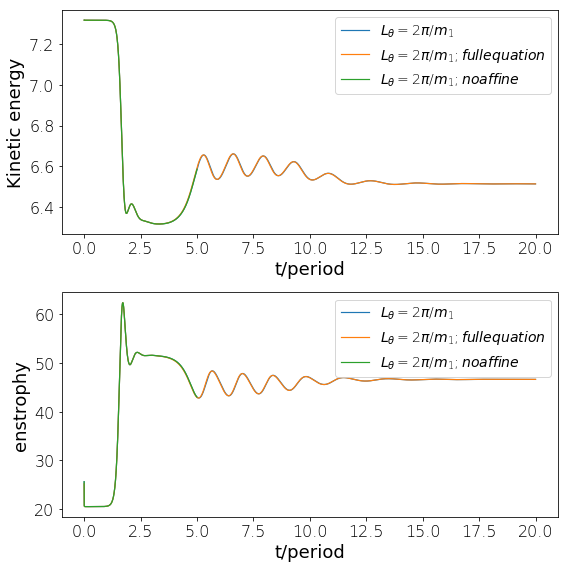

In [253]:
plt.figure(figsize=(8,8))
plt.subplot(211)
plt.plot(run_K.t/run_K.period, run_K.KE*6, label=r'$L_\theta = 2\pi/m_1$')
#plt.plot(run_G.t/run_G.period, run_G.KE, label=r'$L_\theta = 2\pi$')
#plt.plot(run_L.t/run_L.period, run_L.KE, label=r'$L_\theta = 2\pi; full equation$')
#plt.plot(run_M.t/run_M.period, run_M.KE*6, label=r'$L_\theta = 2\pi/m_1; seed 44$')
plt.plot(run_N.t/run_N.period, run_N.KE*6, label=r'$L_\theta = 2\pi/m_1; full equation$')
plt.plot(run_Q.t/run_Q.period, run_Q.KE*6, label=r'$L_\theta = 2\pi/m_1; no affine$')


plt.legend()
plt.xlabel("t/period")
plt.ylabel("Kinetic energy")
plt.subplot(212)
plt.plot(run_K.t/run_K.period, run_K.enstrophy*6, label=r'$L_\theta = 2\pi/m_1$')
#plt.plot(run_G.t/run_G.period, run_G.enstrophy, label=r'$L_\theta = 2\pi$')
#plt.plot(run_L.t/run_L.period, run_L.enstrophy, label=r'$L_\theta = 2\pi; full equation$')
#plt.plot(run_M.t/run_M.period, run_M.enstrophy*6, label=r'$L_\theta = 2\pi/m_1; seed 44$')
plt.plot(run_N.t/run_N.period, run_N.enstrophy*6,label=r'$L_\theta = 2\pi/m_1; full equation$')
plt.plot(run_Q.t/run_Q.period, run_Q.enstrophy*6, label=r'$L_\theta = 2\pi/m_1; no affine$')

plt.legend()
plt.xlabel("t/period")
plt.ylabel("enstrophy")
plt.tight_layout()

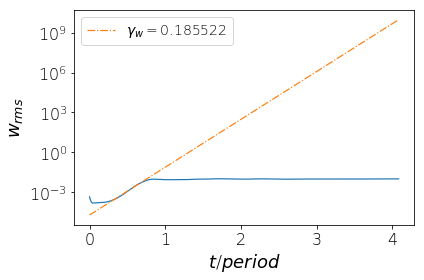

In [86]:
run_O.plot()

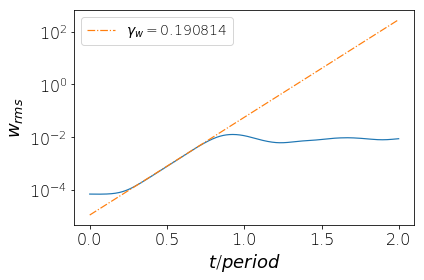

In [173]:
run_P.plot()

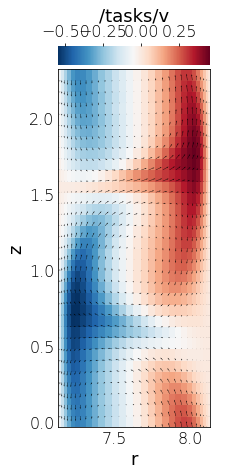

In [87]:
plot_TC_velocity(run_O_snaps,-1)

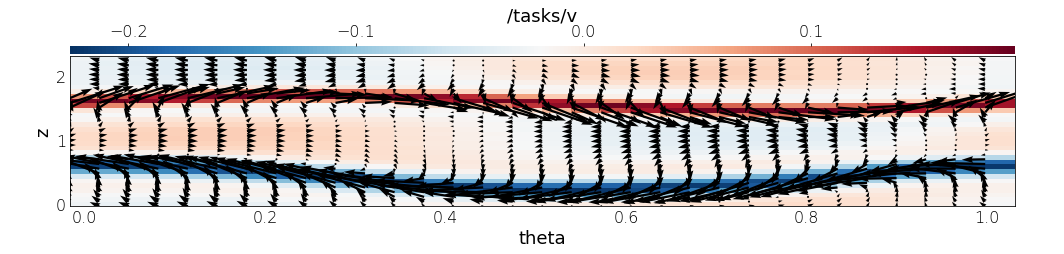

In [88]:
plot_vel_tz(run_O_snaps,-1)

In [243]:
def plot_mk_spectra(data, time_index=-1, r_index=None, field='w',vmin=-3,vmax=1):
    spec = calc_mk_spectra(data, time_index=time_index, r_index=None, field=field)

    box = pt.Box(4,4)
    pad = pt.Frame(0.4, 0.4, 0.1, 0.1)
    margin = pt.Frame(0.4, 0.4, 0.3, 0.3)
    mfig = pt.MultiFigure(1,1,box,pad,margin)
    ax = mfig.add_axes(0,0,[0,0,1,1])

    plt.imshow(np.log(np.abs(spec)),vmin=vmin,vmax=vmax,origin='lower')
    plt.xlabel("m")
    plt.ylabel("k")
    plt.colorbar(label='log $\hat{}$'.format(field))
    
    return spec

def calc_mk_spectra(data, time_index=None, r_index=None, field='w'):
    field_name = 'tasks/'+field
    
    if r_index is None:
        r_index = int(data[field_name].shape[-1]/2)
    
    if time_index is None:
        index = (slice(None), slice(None), slice(None), r_index)
        axes=(1,2)
    else:
        index = (time_index,slice(None),slice(None),r_index)
        axes = None
        
    spec = np.fft.rfftn(data[field_name][index], axes=axes)
        
    return spec

def fold_spec(spectrum):
    nk, nm = spectrum.shape

    k_mid = np.int(np.floor((nk-1)/2))
    end = k_mid+1
    print("k_mid = {}; end = {}; -k_mid-1 = {}".format(k_mid, end, -k_mid-1))
    out_spec = np.zeros([k_mid,nm],dtype='complex')
    out_spec = spectrum[0:end,:]
    out_spec[1:end] += spectrum[-1:-k_mid-1:-1,:]
    
    return out_spec

/home/joishi/miniconda3/envs/dedalus-dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


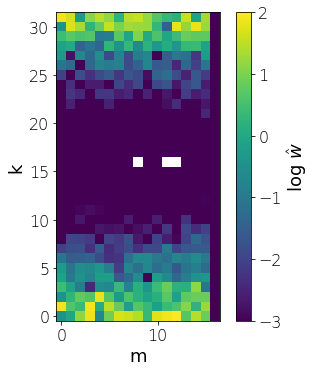

In [218]:
spec = plot_mk_spectra(run_D_snaps,time_index=-1,vmax=2)

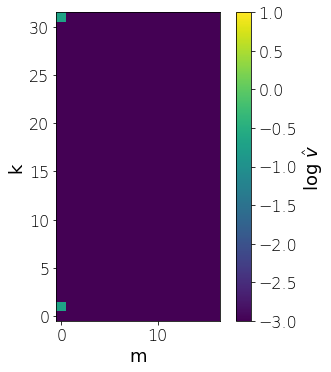

In [247]:
run_P_spec = plot_mk_spectra(run_P_snaps,time_index=0,field='v')

In [202]:
print(run_P_spec[1,0], run_P_spec[-1,0])

(-1.6424492815464653e-16-0.5104799577506477j) (-1.4342824644292485e-16+0.5104799577506478j)


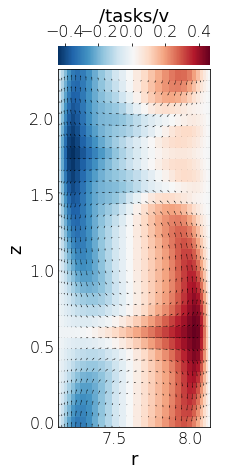

In [177]:
plot_TC_velocity(run_P_snaps, -1)

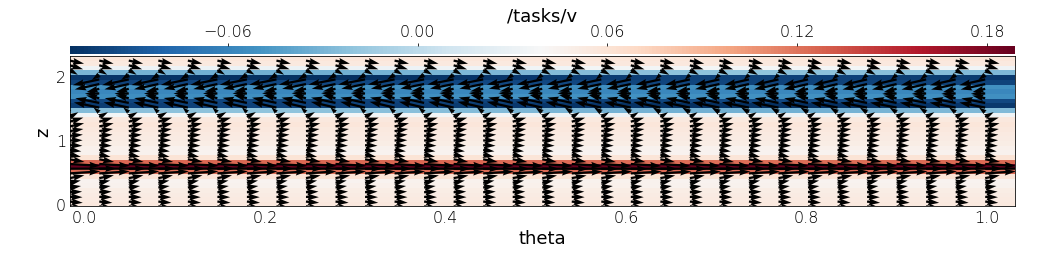

In [183]:
plot_vel_tz(run_P_snaps, -1)

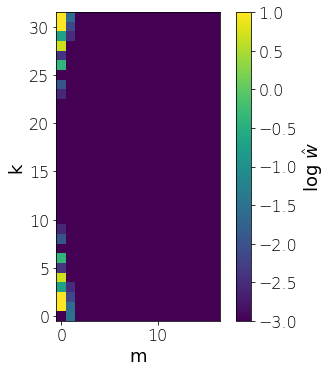

In [249]:
spec = plot_mk_spectra(run_P_snaps,time_index=-1)

In [221]:
def mode_vs_time(data, k, m, r_index=None, field='w'):
    spec = calc_mk_spectra(data, r_index=r_index, field='w')
    
    return spec[:,k,m]

Text(0, 0.5, 'Mode amplitude')

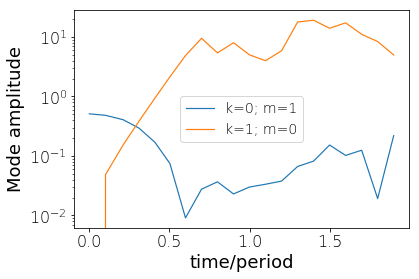

In [251]:
run_P_k1_m1 = mode_vs_time(run_P_snaps, 0,1)
run_P_k1_m0 = mode_vs_time(run_P_snaps, 1,0)
plt.figure()
plt.semilogy(run_P_snaps['scales/sim_time'][:]/run_P.period, np.abs(run_P_k1_m1), label='k=0; m=1')
plt.semilogy(run_P_snaps['scales/sim_time'][:]/run_P.period, np.abs(run_P_k1_m0), label='k=1; m=0')

plt.legend()
plt.xlabel('time/period')
plt.ylabel("Mode amplitude")

In [234]:
run_P_k1_m1[0]/run_P.period

0j